In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob
import import_ipynb as ipynb
import n_most_similar_games as matchup
from bs4 import BeautifulSoup
from collections import Counter
#Cal off. efficiency vs. Clemson efficiency (defense) CLEMSON 92.3
#SAN JOSE ST DEFENSE: 36.5
CAL_OFF = 27.7
OPP_DEF = 2.4


In [2]:
temp = []
data = []
subpxp = []
for year in range(2008,2018):    
    path ='NCAA-Football-Data/' + str(year) + 'PXP' # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
        subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
    data= pd.concat(temp, ignore_index=True)

In [3]:
import cal_football as cf


In [4]:
pxp = cf.extract_data(data)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
# possession_values = cf.get_possession_value(ko_and_pos)

In [109]:
%%capture
game_data, rating_data, pxp_data = matchup.get_ratings()
games_compared, matchup_pxp = matchup.most_similar(off_rating = CAL_OFF, def_rating = OPP_DEF, n = 1500, game_data = game_data, rating_data = rating_data, pxp_data=pxp_data)



#matchup_pxp = cf.extract_data(matchup_pxp)
#matchup_pxp

In [22]:
matchup_pxp.to_csv('matchup_pxp.csv')

In [96]:
matchup_pxp = pd.read_csv('matchup_pxp.csv')

In [63]:
AS;DLFKJAS;DLKFJA;LSKJ


In [ ]:
matchup_pxp.info()


In [ ]:
pxp.info()

In [6]:
ko_and_poss = cf.extract_kickoffs_and_possessions(pxp)

In [8]:
fgs = cf.extract_field_goals(pxp)
third_downs = cf.extract_third_downs(pxp)
punts = cf.extract_punts(pxp)

# ko_and_poss = ko_and_poss.dropna(subset=['score_change'])
# c1 = abs(ko_and_poss.score_change) == 2  
# c2 = abs(ko_and_poss.score_change) == 3 
# c3 = abs(ko_and_poss.score_change) == 6 
# c4 = abs(ko_and_poss.score_change) == 7 
# c5 = abs(ko_and_poss.score_change) == 8
# ko_and_poss = ko_and_poss.loc[c1 | c2 | c3 | c4 | c5]


ekv,epv_model = cf.epv_model(ko_and_poss)
exp_conv_pct_model = cf.exp_conv_pct_model(third_downs)
exp_net_punt_dist_model = cf.exp_net_punt_dist_model(punts)
exp_fg_prob_model = cf.exp_fg_prob_model(fgs)

print(str(ekv))

-0.6


In [9]:
import pandas as pd
import numpy as np

def m_extract_data(pxp):

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam', 'clock']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
#     pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
#                                [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan').astype(int)
    yrdline100arr = []
            
    for index, row in pxp.iterrows():
        if (row['home_off_away_def'] and row['homeTeam'] == row['offenseTeam']) or (row['home_off_away_def']==False and row['awayTeam'] == row['offenseTeam']):
            yrdline100arr.append(100 - row['yardLine'])
        else:
            yrdline100arr.append(row['yardLine'])
    pxp['yrdline100'] = yrdline100arr

    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown')|(pxp['description'].str.contains('TD'))|(pxp['description'].str.contains('Touchdown'))|(pxp['description'].str.contains('TOUCHDOWN')), 1, 0)

    # index of play
    pxp['index'] = range(1, len(pxp) + 1)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
   
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    
    return pxp

In [10]:
def m_o_extract_data(pxp):

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam', 'clock']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
#     pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
#                                [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan').astype(int)
    yrdline100arr = []
            
    for index, row in pxp.iterrows():
        if (row['home_off_away_def'] and row['homeTeam'] == row['offenseTeam']) or (row['home_off_away_def']==False and row['awayTeam'] == row['offenseTeam']):
            yrdline100arr.append(row['yardLine'])
        else:
            yrdline100arr.append(100 - row['yardLine'])
    pxp['yrdline100'] = yrdline100arr

    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown')|(pxp['description'].str.contains('TD'))|(pxp['description'].str.contains('Touchdown'))|(pxp['description'].str.contains('TOUCHDOWN')), 1, 0)

    # index of play
    pxp['index'] = range(1, len(pxp) + 1)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
   
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    
    return pxp

In [110]:
matchup_pxp = matchup_pxp.reset_index(drop=True)

In [111]:
matchup_pxp = m_extract_data(matchup_pxp)

In [ ]:
matchup_pxp.info()


In [112]:
m_ko_and_poss = cf.modified_extract_k_and_p(matchup_pxp)
m_third_downs = cf.extract_third_downs(matchup_pxp)
m_ko_and_poss = m_ko_and_poss.loc[(m_ko_and_poss['homeTeam'] != None)|(m_ko_and_poss['awayTeam']!=None)]

/Users/jeremylevitt/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


In [113]:
m_ko_and_poss = m_ko_and_poss.dropna(subset=['score_change'])
c1 = abs(m_ko_and_poss.score_change) == 2  
c2 = abs(m_ko_and_poss.score_change) == 3 
c3 = abs(m_ko_and_poss.score_change) == 6 
c4 = abs(m_ko_and_poss.score_change) == 7 
c5 = abs(m_ko_and_poss.score_change) == 8
m_ko_and_poss = m_ko_and_poss.loc[c1 | c2 | c3 | c4 | c5]

m_ko_and_poss.info()
m_ko_and_poss.score_change.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13486 entries, 276761 to 330465
Data columns (total 47 columns):
awayAbbr             13486 non-null object
awayId               13486 non-null object
awayScore            13486 non-null object
awayTeam             13486 non-null object
clock                13486 non-null object
defenseAbbr          13486 non-null object
defenseId            13486 non-null object
defenseTeam          13486 non-null object
description          13482 non-null object
distance             13486 non-null object
down                 13486 non-null object
driveIndex           13486 non-null object
endYardLine          13486 non-null object
gameId               13486 non-null object
homeAbbr             13486 non-null object
homeId               13486 non-null object
homeScore            13486 non-null object
homeTeam             13486 non-null object
isScoringPlay        1370 non-null object
offenseAbbr          13486 non-null object
offenseId            13486

array([-3., -7.,  7.,  3., -6.,  6., -2.,  8.,  2., -8.])

m_ko_and_poss.info()

In [114]:
m_ekv, m_epv_model = cf.epv_model(m_ko_and_poss)
m_exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)

yrdline100
0.0     4.738419
1.0     4.644225
2.0     4.550032
3.0     4.455838
4.0     4.361644
5.0     4.267450
6.0     4.173257
7.0     4.079063
8.0     3.984869
9.0     3.890675
10.0    3.796482
11.0    3.702288
12.0    3.608094
13.0    3.513900
14.0    3.419707
15.0    3.325513
16.0    3.231319
17.0    3.137125
18.0    3.042932
19.0    2.948738
20.0    2.854544
21.0    2.760350
22.0    2.666156
23.0    2.571963
24.0    2.477769
25.0    2.383575
26.0    2.289381
27.0    2.195188
28.0    2.100994
29.0    2.006800
          ...   
70.0   -1.855144
71.0   -1.949338
72.0   -2.043532
73.0   -2.137725
74.0   -2.231919
75.0   -2.326113
76.0   -2.420307
77.0   -2.514500
78.0   -2.608694
79.0   -2.702888
80.0   -2.797082
81.0   -2.891275
82.0   -2.985469
83.0   -3.079663
84.0   -3.173857
85.0   -3.268050
86.0   -3.362244
87.0   -3.456438
88.0   -3.550632
89.0   -3.644825
90.0   -3.739019
91.0   -3.833213
92.0   -3.927407
93.0   -4.021601
94.0   -4.115794
95.0   -4.209988
96.0   -4.304182
97.

In [87]:
m_epv_model[49] = 0.5 * (m_epv_model[48] + m_epv_model[50])
m_epv_model

yrdline100
1.0      4.613993
2.0      4.522411
3.0      4.430828
4.0      4.339246
5.0      4.247663
6.0      4.156081
7.0      4.064499
8.0      3.972916
9.0      3.881334
10.0     3.789751
11.0     3.698169
12.0     3.606587
13.0     3.515004
14.0     3.423422
15.0     3.331840
16.0     3.240257
17.0     3.148675
18.0     3.057092
19.0     2.965510
20.0     2.873928
21.0     2.782345
22.0     2.690763
23.0     2.599180
24.0     2.507598
25.0     2.416016
26.0     2.324433
27.0     2.232851
28.0     2.141269
29.0     2.049686
30.0     1.958104
           ...   
71.0    -1.796774
72.0    -1.888356
73.0    -1.979939
74.0    -2.071521
75.0    -2.163103
76.0    -2.254686
77.0    -2.346268
78.0    -2.437851
79.0    -2.529433
80.0    -2.621015
81.0    -2.712598
82.0    -2.804180
83.0    -2.895762
84.0    -2.987345
85.0    -3.078927
86.0    -3.170510
87.0    -3.262092
88.0    -3.353674
89.0    -3.445257
90.0    -3.536839
91.0    -3.628422
92.0    -3.720004
93.0    -3.811586
94.0    -3.903169

In [20]:
epv_model

yrdline100
0      5.054143
1      4.999428
2      4.944714
3      4.889999
4      4.835284
5      4.780569
6      4.725854
7      4.671140
8      4.616425
9      4.561710
10     4.506995
11     4.452280
12     4.397566
13     4.342851
14     4.288136
15     4.233421
16     4.178706
17     4.123992
18     4.069277
19     4.014562
20     3.959847
21     3.905132
22     3.850418
23     3.795703
24     3.740988
25     3.686273
26     3.631558
27     3.576844
28     3.522129
29     3.467414
         ...   
73     1.059963
74     1.005248
75     0.950533
76     0.895818
77     0.841103
78     0.786389
79     0.731674
80     0.676959
81     0.622244
82     0.567529
83     0.512815
84     0.458100
85     0.403385
86     0.348670
87     0.293955
88     0.239241
89     0.184526
90     0.129811
91     0.075096
92     0.020381
93    -0.034333
94    -0.089048
95    -0.143763
96    -0.198478
97    -0.253193
98    -0.307907
99    -0.362622
100   -0.417337
159   -3.645510
162   -3.809655
Name: EPV, Le

In [ ]:
epv_model.to_pickle("./epv_model.pkl")
exp_conv_pct_model.to_pickle("./exp_conv_pct_model.pkl")
exp_net_punt_dist_model.to_pickle("./exp_net_punt_dist_model.pkl")
exp_fg_prob_model.to_pickle("./exp_fg_prob_model.pkl")


In [ ]:
m_epv_model.to_pickle("./m_epv_model.pkl")
m_exp_conv_pct_model.to_pickle("./m_exp_conv_pct_model.pkl")

Punt EPV: -0.8958182960344487

GFI EPV: -0.1752879013143685


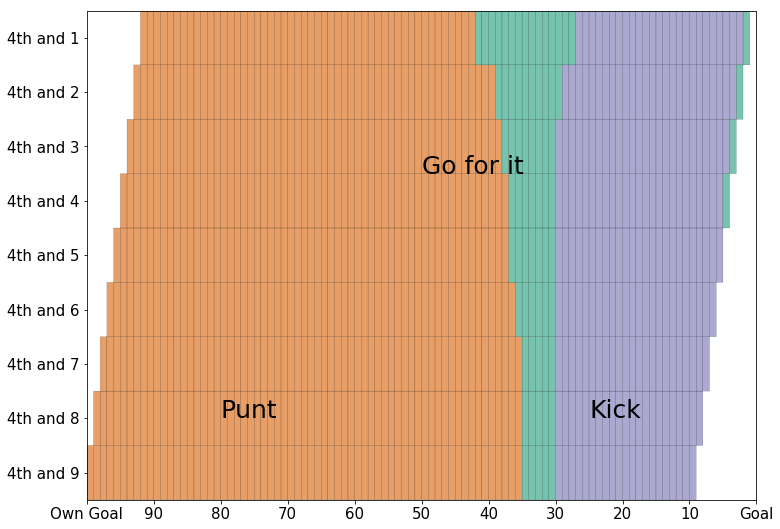

In [123]:
def build_decision_maker(yrdline100, ydstogo, ekv, epv_model, exp_conv_pct_model, 
                         exp_net_punt_dist_model, exp_fg_prob_model,
                        m_ekv, m_epv_model, m_exp_conv_pct_model, m_o_epv_model, 
                         w, just_epvs=False, for_spreadsheet = False):
    
    YRDSTOGO_CAP = 10  # Model restriction
    PUNT_LIM = 29      # Model restriction
    FG_LIM = 63        # Model restriction
    FG_OFFSET = 8      # Field goal placement distance (not including the 10 for the endzone)
    FG_FAIL_RESET = 0  # Where the ball is placed after a failed field goal.  If 0, at the spot.  
                       # Otherwise, at the spot or at the reset spot, whichever is better.
    if yrdline100 < 10:
        region = 'Inside10'
    elif yrdline100 < 20:
        region = '10to20'
    else:
        region = 'Beyond20'
    
        # 1. Expected value of going for it
        
        # Value of failing (approximately turning over at same spot)
    conv_fail_yrdline100 = 100 - yrdline100
    if conv_fail_yrdline100 >=100:
        conv_fail_yrdline100 = 99
    elif conv_fail_yrdline100 < 0:
        conv_fail_yrdline100 = 0
    conv_fail_epv = -epv_model[conv_fail_yrdline100] 
        # Value of converting (approximately at the first down marker)
    if yrdline100 == ydstogo:
        conv_succ_epv = 6 - ekv
        m_conv_succ_epv = 6 - m_ekv
    else:
        first_down_yrdline100 = yrdline100 - ydstogo
        if first_down_yrdline100 <= 0:
            first_down_yrdline100 = 1
        elif first_down_yrdline100 > 99:
            first_down_yrdline100 = 99
        first_down_yrdline100 = int(first_down_yrdline100)
        conv_succ_epv = epv_model[first_down_yrdline100] -1
        if first_down_yrdline100 in m_epv_model:
            m_conv_succ_epv = m_epv_model[first_down_yrdline100] - 1
        else:
            m_conv_succ_epv = 0.5 * (m_epv_model[first_down_yrdline100 - 1] + m_epv_model[first_down_yrdline100 + 1])

#         print("\nYard Line: " + str(yrdline100) + "     Yds to go: " + str(ydstogo) + "\nNeg EPV: " + 
#               str(m_conv_fail_epv) + "\nPos EPV: " + str(m_conv_succ_epv))
        # Conversion Pct
    
    exp_conv_pct = exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
    m_exp_conv_pct = m_exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
        
        # Overall expected value of going for it
    unmod_go_ev = exp_conv_pct * conv_succ_epv + (1 - exp_conv_pct) * conv_fail_epv
#     print("\nYard Line: " + str(yrdline100) + "     Yds to go: " + str(ydstogo) + "\nConversion: " +str(exp_conv_pct) + "\nNeg EPV: " + 
#          str(conv_fail_epv) + "\nPos EPV: " + str(conv_succ_epv))
    m_go_ev = m_exp_conv_pct * m_conv_succ_epv + (1 - m_exp_conv_pct) * conv_fail_epv
    go_ev = w * m_go_ev + (1 - w) * unmod_go_ev
    if just_epvs:
        return conv_succ_epv, m_conv_succ_epv
        ####THIS IS WHERE YOU ADD THE MATCHUP EPV WEIGHT AND STUFF (ABOVE)
        
        
        
        
        # 2. Expected value of punting
        
        # Expected next yardline
    if yrdline100 >= PUNT_LIM:
        exp_net_punt_dist = exp_net_punt_dist_model[yrdline100]
#         print("\nYrdLine: " + str(yrdline100) + ("\nYrdstogo: ") + str(yrdstogo) + "\nExp Dist: " +  str(exp_net_punt_dist))
        exp_yrdline100 = 100 - (yrdline100 - int(exp_net_punt_dist))
        if exp_yrdline100 > 99:
            exp_yrdline100 = 99
        elif exp_yrdline100 < 0:
            exp_yrdline100 = 0
            # Overall expected value of punting
        punt_ev = -epv_model[exp_yrdline100]
    else:
        punt_ev = None
        
    #Calculating delay of game punt decision
    adj_yrdline100 = yrdline100 + 5
    if adj_yrdline100 >= PUNT_LIM and adj_yrdline100 < 100:
        aexp_net_punt_dist = exp_net_punt_dist_model[adj_yrdline100]
        aexp_yrdline100 = 100 - (adj_yrdline100 - int(aexp_net_punt_dist))
        if aexp_yrdline100 > 99:
            aexp_yrdline100 = 99
        elif aexp_yrdline100 < 0:
            aexp_yrdline100 = 0
            # Overall expected value of punting
        punt_dog = -epv_model[aexp_yrdline100]
    else:
        punt_dog = None
#     punt_dog = -100
            
        # 3. Expected value of kicking a field goal
    fg_dist =  yrdline100 + 18 + FG_OFFSET
    if fg_dist <= FG_LIM:
        # Probability of success
        exp_fg_prob = exp_fg_prob_model[fg_dist ]

        # Expected value of field success
        fg_succ_epv = 3 - ekv

        # EPV of field goal fail
        fg_fail_yrdline100 = 100 - yrdline100 - FG_OFFSET
        fg_fail_epv = -epv_model[fg_fail_yrdline100]

        # Overall expected value kicking
        fg_ev = fg_succ_epv * exp_fg_prob + fg_fail_epv * (1 - exp_fg_prob)
    else:
        fg_ev = None
    if fg_ev is not None and fg_ev < 0:
        fg_ev = None
    
    
    
    choices = [('go for it', go_ev), ('punt', punt_ev), ('kick', fg_ev), ('puntDOG', punt_dog)]
    max_val = -100
    for choice, ev in choices:
        if ev is None:
            continue
        if ev > max_val:
            max_val = ev
            decision = choice
    note = ''
    if decision == 'puntDOG':
        note = 'Take delay of game.'
        decision = 'punt'
    
        
            
    max_val = -100
    remaining = []
    if decision == 'go for it':
        remaining = [('punt', punt_ev), ('kick', fg_ev)]
    elif decision == 'punt':
        remaining = [('go for it', go_ev), ('kick', fg_ev)]
    elif decision == 'kick':
        remaining = [('go for it', go_ev), ('punt', punt_ev)]
    sec_decision = ''
    for choice, ev in remaining:
        if ev is None:
            continue
        if ev > max_val:
            max_val = ev
            sec_decision = choice
    if decision == 'puntDOG':
        note = 'Take delay of game.'
        decision = 'punt'
        punt_ev = punt_dog
    if decision == 'kick' and yrdline100 > 24:
        note = 'If individual kicker out of range, next decision is: ' + sec_decision + '.'
    if go_ev is not None and fg_ev is not None:
        if decision == 'go for it' and abs(go_ev - fg_ev) <= 0.2 and yrdline100 < 24:
            note = 'If more reliable points needed, consider FG.'
    if for_spreadsheet:
        return decision, go_ev, punt_ev, fg_ev, conv_fail_epv, note
    else:
        return decision, punt_ev, go_ev

# Build the decision maker

yrdlines = list(range(1, 100))
down_dist = list(range(1, 10))

decisions = []
for yrdstogo in down_dist:
    tmp = []
    for yrdline in yrdlines:
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            decision, p_ev, go_ev = build_decision_maker(yrdline, yrdstogo, 
                                            ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model,
                                            exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model,
                                                         m_o_epv_model, 1)
            if yrdline== 30:
                if yrdstogo == 5:
                    print("Punt EPV: " + str(p_ev))
                    print("\nGFI EPV: " + str(go_ev))
            tmp.append(decision)
        else:
            tmp.append(None)
    decisions.append(tmp)
# Convert to a table
pd.DataFrame(decisions, columns=yrdlines, index=down_dist)

import numpy as np
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = decisions[i][j]
        if decision == 'go for it':
            val = 1
        elif decision == 'punt':
            val = 2
        elif decision == 'kick':
            val = 3
        elif decision is None:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin=1,
    vmax=8,
    edgecolors='k', 
    linewidths=.2,
    cmap=plt.get_cmap('Dark2'),
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['Own Goal', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([
    yd - .5
    for yd in range(1, 10)
])
ax.set_yticklabels([
    '4th and {}'.format(yd)
    for yd in range(9, 0, -1)
])
ax.text(50, 6, 'Go for it', size=25)
ax.text(20, 1.5, 'Punt', size=25)
ax.text(75, 1.5, 'Kick', size=25)
ax.tick_params(axis='both', which='major', labelsize=15);

### 

In [122]:
avg_epv = []
mod_epv = []
for yrdstogo in range(1, 10):
    tmp_avg = []
    tmp_mod = []
    for yrdline in range(1, 100):
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            avg, mod = build_decision_maker(yrdline, yrdstogo, 
                                            ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, 
                                            exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model, m_o_epv_model, 0.9, just_epvs=True)
            tmp_avg.append(avg)
            tmp_mod.append(mod)
        else:
            tmp_avg.append(None)
            tmp_mod.append(None)
    avg_epv.append(tmp_avg)
    mod_epv.append(tmp_mod)

with open('avg_epv.py', 'w') as out:
    print('avg_epv =', avg_epv, file = out)
with open('mod_epv_UCONN.py', 'w') as out:
    print('mod_epv =', mod_epv, file = out)

def get_output():
    decisions = []
    gfi_epv = []
    fg_epv = []
    p_epv = []
    yrdstogo_arr = []
    yrdline_arr = []
    for yrdstogo in down_dist:
        tmp_avg = []
        tmp_mod = []
        for yrdline in yrdlines:
            yrdstogo_arr.append(yrdstogo)
            yrdline_arr.append(yrdline)
            if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
                decision, gfi, fg, p  = build_decision_maker(yrdline, yrdstogo, 
                                                ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, 
                                                exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model, 0.3, for_spreadsheet=True)
                decisions.append(decision)
                gfi_epv.append(gfi)
                fg_epv.append(fg_epv)
                p_epv.append(p)
            else:
                decisions.append(None)
                gfi_epv.append(None)
                fg_epv.append(None)
                p_epv.append(None)
    output_pxp = pd.DataFrame()
    output_pxp['yrdline100'] = np.array(yrdline_arr)
    output_pxp['yrdstogo'] = np.array(yrdstogo_arr)
    output_pxp['decision'] = np.array(decisions)
    output_pxp['gfi_epv'] = np.array(gfi_epv)
    output_pxp['fg_epv'] = np.array(fg_epv)
    output_pxp['punt_epv'] = np.array(p_epv)
    return output_pxp

In [105]:
def get_output(w):
    decisions = []
    gfi_epv = []
    fg_epv = []
    p_epv = []
    yrdstogo_arr = []
    yrdline_arr = []
    neg_epv = []
    notes = []
    for yrdstogo in range(1, 10):
        for yrdline in range(1, 100):
            yrdstogo_arr.append(yrdstogo)
            yrdline_arr.append(yrdline)
            if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10):
                decision, gfi, p, fg, neg, note = build_decision_maker(yrdline, yrdstogo, ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, 
                                                                 exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model, 
                                                                 m_o_epv_model, w, for_spreadsheet=True)
            else:
                decision, gfi, fg, p, neg, note = None, None, None, None, None, None
                note = 'Not Possible.'
            
            neg_epv.append(neg)
            
            gfi_epv.append(gfi)
            if fg is not None:
                if fg < 0:
                    fg = None
            fg_epv.append(fg)
            p_epv.append(p)
            decisions.append(decision)
            
            
            notes.append(note)
    adjusted_fg = []
#     for x in range(891):
#         if x >= 8:
#             adjusted_fg.append(fg_epv[x])
#         elif x>=98:
#             adjusted_fg.append(None)
#         elif x >= 108:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 198:
#             adjusted_fg.append(None)
#         elif x >= 208:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 298:
#             adjusted_fg.append(None)
#         elif x >= 308:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 398:
#             adjusted_fg.append(None)
#         elif x >= 408:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 498:
#             adjusted_fg.append(None)
#         elif x >= 508:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 598:
#             adjusted_fg.append(None)
#         elif x >= 608:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 698:
#             adjusted_fg.append(None)
#         elif x >= 708:
#             adjusted_fg.append(fg_epv[x])
#         elif x>= 798:
#             adjusted_fg.append(None)
#         elif x >= 808:
#             adjusted_fg.append(fg_epv[x])
#     for x in range(8):
#         adjusted_fg.append(None)
#     print(str(len(adjusted_fg)))
#     print(str(len(fg_epv)))
#     max_ev = -100
#     for x in range(len(gfi_epv)):
#         if gfi_epv[x] is not None:
#             max_ev = gfi_epv[x]
#             decision = 'go for it'
#         if adjusted_fg[x] is not None:
#             if max_ev < adjusted_fg[x]:
#                 max_ev = adjusted_fg[x]
#                 decision = 'kick'
#         if p_epv[x] is not None:
#             if max_ev < p_epv[x]:
#                 max_ev = p_epv[x]
#                 decision = 'punt'
#         if max_ev == -100:
#     max_ = -100
#     for x in range (len(fg_epv)):
#         if fg_epv[x] is not None:
#             if fg_epv[x] > max_:
#                 max_ = fg_epv[x]
#     diff = max_ - 3
#     for x in range(len(fg_epv)):
#         if fg_epv[x] is not None:
#             fg_epv[x] -= diff
#         if gfi_epv[x] is not None:
#             gfi_epv[x] -= diff
#     for x in range (len(gfi_epv)):  
#         choices = []
#         if x < 95:
#             choices = [('go for it', gfi_epv[x]), ('punt', p_epv[x]), ('puntDOG', p_epv[x+5]), ('kick', fg_epv[x])]
#         else:
#             choices = choices = [('go for it', gfi_epv[x]), ('punt', p_epv[x]), ('kick', fg_epv[x])]
#         max_val = -100
#         for choice, ev in choices:
#             if ev is None:
#                 continue
#             if ev > max_val:
#                 max_val = ev
#                 decision = choice
        
#         decisions.append(decision)
    
    output_pxp = pd.DataFrame()
    output_pxp['Notes'] = np.array(notes)
    output_pxp['Negative (Turnover) EPV'] = np.array(neg_epv)
    output_pxp['Suggested Decision'] = np.array(decisions)
    output_pxp['yrdline100'] = np.array(yrdline_arr)
    output_pxp['yrdstogo'] = np.array(yrdstogo_arr)
    output_pxp['gfi_epv'] = np.array(gfi_epv)
    output_pxp['fg_epv'] = np.array(fg_epv)
    output_pxp['punt_epv'] = np.array(p_epv)
    return output_pxp
         
        
        
        
        
        

In [62]:
from create_final_decision import create_final_output


In [106]:
pxp_out = get_output(0.7)


In [107]:
rando_pxp = pd.DataFrame()
rando_pxp['avg_conv'] = pd.Series()
rando_pxp['mod_conv'] = pd.Series()
create_final_output_inner(pxp_out, rando_pxp)

/Users/jeremylevitt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [104]:
import pandas as pd
import numpy as np
def create_final_output_inner(pxp, conv_pxp):
    writer = pd.ExcelWriter('final_output_CAL_VS_SANJOSEST.xlsx')
    for x in np.arange(1, 10):
        temp = pd.concat([pxp[pxp.yrdstogo == x], conv_pxp[pxp.yrdstogo == x]], axis=1).drop("yrdstogo", axis=1)
        
        suggestions = []

#         for index, row in temp.iterrows():
#             if row.gfi_epv and row.fg_epv and row.punt_epv is not None:
#                 if max(row.gfi_epv, row.fg_epv, row.punt_epv) == row.gfi_epv:
#                     suggestions.append("Go")
#                 if max(row.gfi_epv, row.fg_epv, row.punt_epv) == row.fg_epv:
#                     suggestions.append("Field Goal")
#                 if max(row.gfi_epv, row.fg_epv, row.punt_epv) == row.punt_epv:
#                     suggestions.append("Punt")
#             else:
#                 suggestions.append(None)
        final_m_conv = []
        temp['mod_conv'] = pd.read_csv('./mod_conv_pct_sanjosest.csv')
        for index, row in temp.iterrows():
            if row['yrdline100'] < x:
                final_m_conv.append(None)
            else:
                final_m_conv.append(row['mod_conv'])
        temp['mod_conv'] = final_m_conv
        temp.to_excel(writer, '4th and ' + str(x), index=False)
    writer.save()


In [ ]:
pxp_out

In [ ]:
pxp_out.to_csv('save_pxp.csv')

In [ ]:
pxp_out = pd.read_csv('save_pxp.csv')

In [ ]:
avg_epv

In [ ]:
mod_epv

In [ ]:
path = "Test_File.csv"
cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
df = pd.read_csv(path,index_col=None, header=0, usecols=cols)
df["home_off_away_def"] = np.repeat(True, len(df))
testpxp = cf.m_extract_data(df)
m_ko_and_poss = cf.modified_extract_k_and_p(testpxp)
m_third_downs = cf.extract_third_downs(testpxp)
m_ekv, m_epv_model = cf.epv_model(m_ko_and_poss)
m_exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)
m_epv_model

In [ ]:
path = "Test_File.csv"
cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
df = pd.read_csv(path,index_col=None, header=0, usecols=cols)
testpxp = extract_data(df)
m_ko_and_poss = cf.extract_kickoffs_and_possessions(testpxp)
m_third_downs = cf.extract_third_downs(testpxp)
ekv, epv_model = cf.epv_model(m_ko_and_poss)
exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)
epv_model

In [ ]:
def extract_data(pxp):

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam', 'clock']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
                                (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
                               [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan')
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']),
                                (pxp['awayTeam'] == pxp['offenseTeam'])], 
                               [100-pxp['yardLine'], pxp['yardLine']], default=None).astype(float)
    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown')|(pxp['description'].str.contains('TD'))|(pxp['description'].str.contains('Touchdown'))|(pxp['description'].str.contains('TOUCHDOWN')), 1, 0)

    # index of play
    pxp['index'] = range(1, len(pxp) + 1)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
    fgcondition = [(pxp['type']=='Field Goal Good'), 
                (pxp['type']=='Field Goal Missed'),
                (pxp['type']=='Missed Field Goal Return'),
                (pxp['type']=='Missed Field Goal Return Touchdown'),
                (pxp['type']=='Blocked Field Goal'),
                (pxp['type']=='Blocked Field Goal Touchdown')]
    pxp['FieldGoalResult'] = np.select(fgcondition, ['Good', 'No Good', 'No Good', 'No Good', 'Blocked', 'Blocked'])
    pxp['FieldGoalResult'] = pxp['FieldGoalResult'].replace('0', np.nan)
    
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)
    pxp.loc[(pxp['type'].isin(['Field Goal Good','Field Goal Missed','Blocked Field Goal'])),'FieldGoalDistance']=pxp['yardsGained']
    pxp.loc[(pxp['type'].isin(['Missed Field Goal Return', 'Missed Field Goal Return Touchdown','Blocked Field Goal Touchdown'])),'FieldGoalDistance']=pxp['yrdline100']


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    try:
        pxp['yrdline100'] = [int(x) for x in pxp['yrdline100']]
    except ValueError:
        do_nothing = 2
    return pxp